# Near earth objects

#### https://cneos.jpl.nasa.gov/ca/

In [24]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter

In [25]:
now = datetime.now()
now = now.strftime("%Y-%m-%d")
now

'2021-12-29'

### Filter, Variablen

In [26]:
filter_entfernung = 20         # Entfernung in Lunar Distances (float)
filter_time = "2121-12-31"     # bis zu diesem Datum werden Daten angezeigt
bool_Top5 = False              # Top 5 Size Text an / aus
bool_ISS = False               # ISS Orbit anzeigen / nicht anzeigen
bool_geostationary = False     # geostationary Orbit anzeigen / nicht anzeigen
bool_moon = True               # moon Orbit anzeigen / nicht anzeigen

pfad = "D:\\Github\\Science\\NEO\\"

### data import, cleaning

In [27]:
df = pd.read_csv(pfad + "cneos_closeapproach_data.csv", sep=",")
df = df.drop(columns=['CA Distance Minimum (LD | au)', 'V relative (km/s)', 'V infinity (km/s)', 'H (mag)', 'Unnamed: 8'])

In [28]:
df["LD"] = df["CA Distance Nominal (LD | au)"].str.split(' ', expand = True)[0]
df["LD"] = pd.to_numeric(df["LD"], errors='coerce')

### Datum

In [29]:
df["Datum"] = df["Close-Approach (CA) Date"].str[:11]
df["Datum"] = pd.to_datetime(df["Datum"], errors='coerce', utc=True)
df = df.sort_values(by='Datum', ascending=True)

### calculation

In [30]:
df["distance_km"] = df["LD"] * 394_399
df["zero"]= 0
df["earth"] = 2 * 6_371
df["ISS"] = df["earth"] + 408
df["geostationary"] = df["earth"] + 35_786
df["moon"] = 394_399

### size

In [31]:
# km oder m auslesen
df["size_unit"] = df["Diameter"].str[-2:]

# Teile alle Durchmesser mit ±
df["d1"] = df["Diameter"].str.split('±', expand = True)[0]
df["d1"] = pd.to_numeric(df["d1"], errors='coerce')

# definiere size factor = 1000, ausser bei " m" = 1
df["size_factor"] = 1_000
df.loc[df["size_unit"] == " m", "size_factor"] = 1
df.head(3)

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),Diameter,LD,Datum,distance_km,zero,earth,ISS,geostationary,moon,size_unit,d1,size_factor
5805,(2021 YL),2021-Dec-28 11:22 ± 00:41,12.86 | 0.03304,21 m - 48 m,12.86,2021-12-28 00:00:00+00:00,5071971.14,0,12742,13150,48528,394399,m,NaN,1
3316,(2017 AE3),2021-Dec-29 01:54 ± 6_06:03,9.22 | 0.02370,120 m - 260 m,9.22,2021-12-29 00:00:00+00:00,3636358.78,0,12742,13150,48528,394399,m,NaN,1
19,(2021 YK),2022-Jan-02 17:14 ± 07:46,0.50 | 0.00128,8.9 m - 20 m,0.50,2022-01-02 00:00:00+00:00,197199.50,0,12742,13150,48528,394399,m,NaN,1


In [32]:
# mittlerer Durchmesser ermitteln

df["d_von"] = df["Diameter"].str.split(' ', expand = True)[0]
df["d_von"] = pd.to_numeric(df["d_von"], errors='coerce')

df["d_bis"] = df["Diameter"].str.split('- ', expand = True)[1]
df["d_bis"] = df["d_bis"].str.split(' m', expand = True)[0]
df["d_bis"] = pd.to_numeric(df["d_bis"], errors='coerce')

df["mittel1"] = df["d1"] * df["size_factor"]
df["mittel1"] = df["mittel1"].fillna(1)

df["mittel2"] = (df["d_von"]+df["d_bis"]) *(1/2) * df["size_factor"]
df["mittel2"] = df["mittel2"].fillna(1)

df["diameter_mean"] = df["mittel1"] * df["mittel2"]

df = df.drop(columns=['d1', 
                      'd_von', 
                      'd_bis', 
                      'mittel1', 
                      'mittel2', 
                      'size_factor', 
                      'CA Distance Nominal (LD | au)', 
                      'size_unit',
                      'Close-Approach (CA) Date'])

# df

In [33]:
df = df.loc[df["LD"] < filter_entfernung]

In [34]:
df["Datum"].dtypes

datetime64[ns, UTC]

In [35]:
df = df[(df['Datum'] > now) & (df['Datum'] < filter_time)]

# df = df.loc[df["Datum"] < filter_entfernung]

In [36]:
max_größe = df["diameter_mean"].max()
df["marker_size"] = 300 * (df["diameter_mean"] / max_größe)
max_größe

6250.0

### Position Textboxen

In [37]:
df = df.sort_values(by='Datum', ascending=True)
df.index = np.arange(1, len(df) + 1 )
df["x_axis"] = df.index

x_achse_max = df["x_axis"].max()
print(x_achse_max)
df["pos_x_achse"] = (df["x_axis"] / x_achse_max)*0.90

8008


In [38]:
df = df.sort_values(by='distance_km', ascending=True)
y_achse_max = df["distance_km"].max()
print(y_achse_max)
df["pos_y_achse"] = (df["distance_km"] / y_achse_max)*0.97

7675004.54


In [39]:
# definiere size factor = 1000, ausser bei " m" = 1
df = df.sort_values(by='diameter_mean', ascending=False)
df.index = np.arange(1, len(df) + 1 )
df["x_axis"] = df.index

df.loc[df["x_axis"] <=5 , "Top5"] = df["Object"]
df["Top5"] = df["Top5"].fillna("")
df = df.sort_values(by='diameter_mean', ascending=True)

In [40]:
df = df.sort_values(by='Datum', ascending=True)

### visualize

<Figure size 576x396 with 0 Axes>

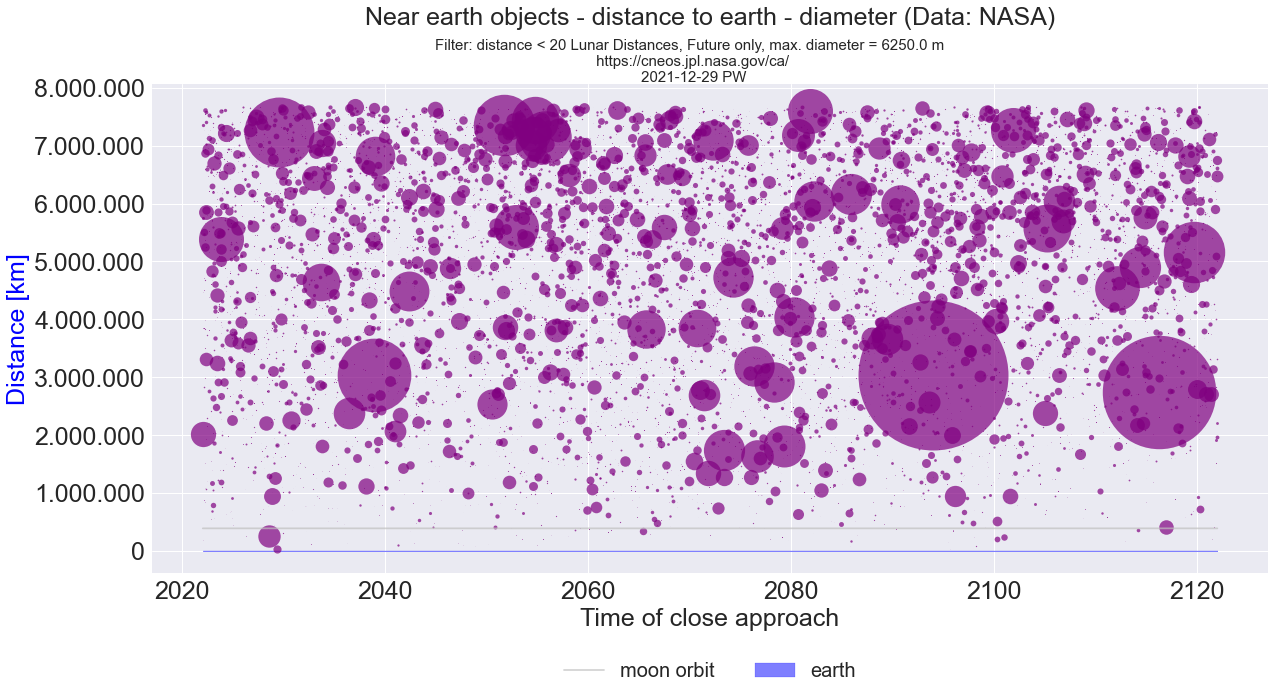

In [41]:
plt.clf()

def y_axis_thousands(x, pos):
    # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",", ".")

plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(20, 9))
formatter = FuncFormatter(y_axis_thousands)
ax.yaxis.set_major_formatter(formatter)

# plt.plot(df["distance_km"],color="blue", alpha=0.7, marker=".", markersize=marker_size_list1,
#          linestyle="", label="Near earth object")


[ax.plot(row['Datum'], row['distance_km'], '.', markersize=row['marker_size'], alpha=0.7, color = "purple", label = "") for idx, row in df.iterrows()]

if bool_Top5 == True:
    [ax.text(row['pos_x_achse'], row['pos_y_achse'], row['Top5'], horizontalalignment='center', color="black", alpha=1, verticalalignment='center', transform=ax.transAxes, size=15) for idx, row in df.iterrows()]

# plt.plot(df["zero"],color="brown", alpha=0.7, marker="", markersize=10,
#          linestyle="-", label="")

# plt.plot(df["earth"],color="brown", alpha=0.7, marker="", markersize=10,
#          linestyle="-", label="")

plt.fill_between(df["Datum"], df['earth'], df['zero'], color='blue', alpha=0.5,
                 label=f'earth')

if bool_geostationary == True:
    plt.plot(df["Datum"], df["geostationary"],color="red", alpha=0.7, marker="", markersize=10,
             linestyle="-", label="geostationary orbit")

if bool_ISS == True:
    plt.plot(df["Datum"], df["ISS"],color="orange", alpha=0.7, marker="", markersize=10,
             linestyle="-", label="ISS orbit")

if bool_moon == True:
    plt.plot(df["Datum"], df["moon"],color="silver", alpha=0.7, marker="", markersize=10,
             linestyle="-", label="moon orbit")


# ax.text(0, 0, "(0,0)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
# ax.text(0, 1, "(0,1)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
# ax.text(1, 0, "(1,0)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
# ax.text(0.5, 0.5, "(0.5,0.5)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)
# ax.text(1, 1, "(1,1)", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, size=15)

ax.set_xlabel("Time of close approach", fontsize=25)
ax.set_ylabel("Distance [km]", color="blue", fontsize=25)

ax.tick_params(labelsize=25)

plt.legend(loc='center',
           bbox_to_anchor=(0.5, -0.2),
           fancybox=True,
           shadow=True,
           ncol=4,
           fontsize=20)

plt.title(f' Near earth objects - distance to earth - diameter (Data: NASA) \n\n', fontsize=25)
plt.suptitle(f'Filter: distance < {filter_entfernung} Lunar Distances, Future only, max. diameter = {max_größe} m \n https://cneos.jpl.nasa.gov/ca/ \n {now} PW', fontsize=15, y=0.95)

plt.savefig(f'D:\\Github\\Science\\NEO\\NEO_{filter_entfernung} Lunar Distances.png', dpi=300, bbox_inches='tight')



### Excel Export

In [42]:
df["Datum"] = df["Datum"].dt.strftime("%d.%m.%Y")

df.to_excel(pfad + "Excel Export.xlsx")

### Berechnung für Normalverteilung aus den Daten

In [62]:
mean = int(df["distance_km"].mean())     # Mittelwert
print(f' mean = {mean}')

sigma = int(df["distance_km"].std())     # Standardabweichung
print(f' sigma = {sigma}')

 mean = 4769333
 sigma = 1924243


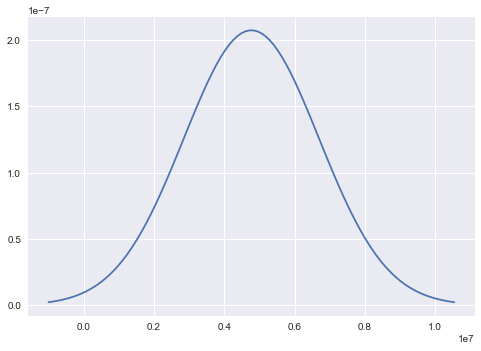

In [49]:
import scipy.stats as stats
import math

x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mean, sigma))
plt.show()

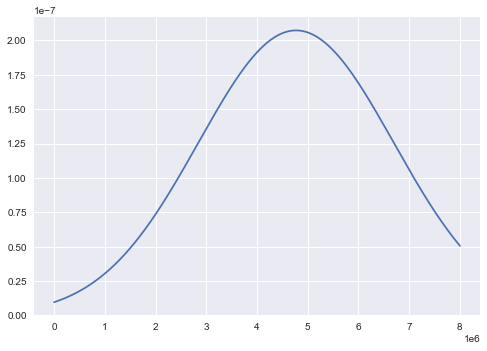

In [60]:
from scipy.stats import norm
import statistics

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 8_000_000, 1)

plt.plot(x_axis, norm.pdf(x_axis, mean, sigma))
plt.show()

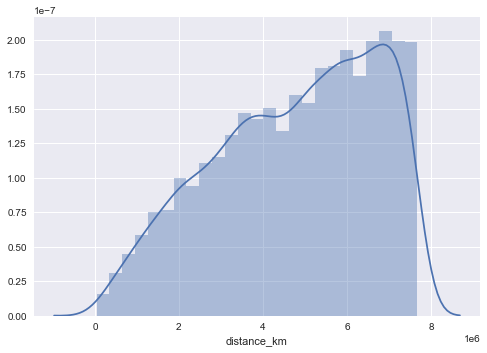

In [56]:
import seaborn as sns

sns.distplot(df["distance_km"])

AttributeError: module 'seaborn' has no attribute 'histplot'

In [72]:
from scipy.integrate import quad
def f(x):
    return 3.0 * x**2 + 1
print(f(1.8))

i = quad(f, 0, 2)
print(i)
print(i[0])

10.72
(10.000000000000002, 1.1102230246251568e-13)
10.000000000000002
